# 자전거 대여 수요 예측 - 회귀 

## 데이터 가져오기

In [52]:
import pandas as pd

bike_df = pd.read_csv('./bike/train.csv')
print(bike_df.shape)
print(bike_df.head())
bike_df.info()

(10886, 12)
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime   

## 전처리

In [53]:
#datetime을 날짜 타입으로 변경
bike_df['datetime'] = bike_df['datetime'].apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [54]:
#날짜를 년 월 일 시간으로 분할
bike_df['year'] = bike_df['datetime'].apply(lambda x : x.year)
bike_df['month'] = bike_df['datetime'].apply(lambda x : x.month)
bike_df['day'] = bike_df['datetime'].apply(lambda x : x.day)
bike_df['hour'] = bike_df['datetime'].apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [55]:
#불필요한 컬럼 제거
drop_c = ['datetime', 'casual', 'registered']
bike_df.drop(drop_c, axis = 1, inplace = True)
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [56]:
#downcasting 함수 
def downcast(df) :
    #메모리 사용량 확인
    start_m = df.memory_usage().sum() / 1024
    
    for i in df.columns:
        dtype_name = df[i].dtype.name
        if dtype_name == 'object' :
            pass
        elif dtype_name == 'bool' :
            df[i] = df[i].astype('int8')
        elif dtype_name.startswith('int') or (df[i].round() == df[i]).all() :
            df[i] = pd.to_numeric(df[i], downcast='integer')
        else :
            df[i] = pd.to_numeric(df[i], downcast='float')
            
    end_m = df.memory_usage().sum() / 1024
    print( 100*(start_m - end_m ) /start_m, "% 압축됨" )
    return df
    
bike_df = downcast(bike_df)

76.91438099679229 % 압축됨


In [57]:
import gc

gc.collect()

32

In [61]:
#평가 지표를 위한 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#rmsle를 구해주는 함수 
def rmsle(y, pred):
    #log 함수는 NaN에서 문제가 발생하기 때문에 log1p함수를 이용
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) **2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred) :
    rmsle_v = rmsle(y,pred)
    rmse_v = rmse(y,pred)
    mae_v = mean_absolute_error(y,pred)
    print('RMSLE:{0}, RMSE:{1}, MAE:{2}'.format(rmsle_v, rmse_v, mae_v))

## 단순 선형 회귀 수행

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)


X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
                     
evaluate_regr(y_test ,pred)





RMSLE:1.173545002937317, RMSE:141.26170349121094, MAE:105.67913818359375


C:\Users\USER\AppData\Local\Temp\ipykernel_17952\3425157742.py:9: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


In [63]:
#오차가 큰 값 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
get_top_error_data(y_test,pred,n_tops=5)

    

      real_count  predicted_count   diff
1094         977            391.0  586.0
361          948            366.0  582.0
1872         890            325.0  565.0
1654         888            327.0  561.0
1841         884            326.0  558.0


## 타겟을 수정한 후 ( 로그 변환 ) 모델을 다시 훈련

<Axes: >

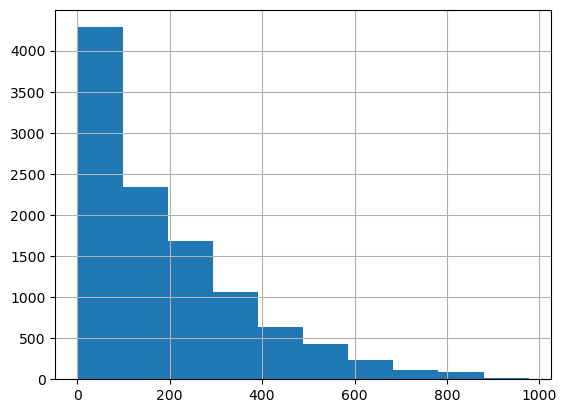

In [65]:
#분포 확인
y_target.hist()

<Axes: >

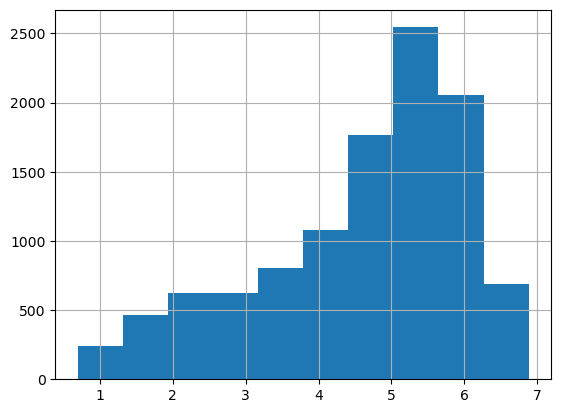

In [67]:
#타겟의 로그 변환 
y_log_t = np.log1p(y_target)
y_log_t.hist()

In [70]:
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#로그 변환 한 값을 원래의 값으로 되돌려야 함
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.0202172994613647, RMSE:160.72909545898438, MAE:108.23526763916016


## 피처를 원 핫 인코딩 한 후 수행

<Axes: >

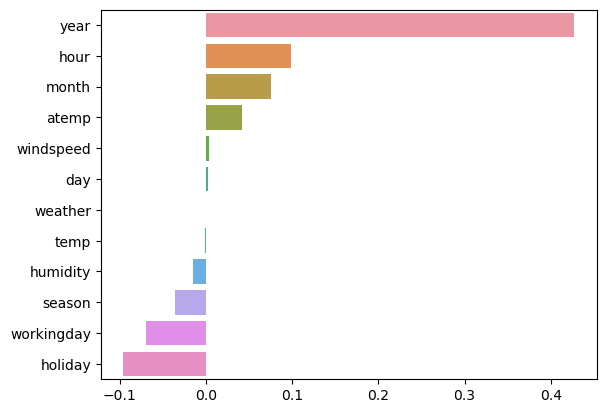

In [71]:
#회귀 계수를 확인

coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)

import seaborn as sns
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [72]:
#원 핫 인코딩 
X_features_ohe = pd.get_dummies(X_features , columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [73]:
#모델과 데이터를 받아서 훈련하고 평가 지표를 출력하는 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)


In [75]:
#선형 회귀 모델 수행
lr_reg = LinearRegression()
get_model_predict(lr_reg,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE:1.0202172994613647, RMSE:160.72909545898438, MAE:108.23526763916016


## 규제 모델을 이용한 훈련

In [76]:
#규제 모델을 사용하면 선형 회귀보다는 성능이 좋아질 가능성 높음 
from sklearn.linear_model import Ridge , Lasso
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)


get_model_predict(ridge_reg,X_train, X_test, y_train, y_test,is_expm1=True)
get_model_predict(lasso_reg,X_train, X_test, y_train, y_test,is_expm1=True)

### Ridge ###
RMSLE:1.0202099084854126, RMSE:160.72789001464844, MAE:108.23233795166016
### Lasso ###
RMSLE:1.0210789442062378, RMSE:160.79490661621094, MAE:108.29631805419922


## 트리 모델 적용

(533, 800, 3)


(-0.5, 799.5, 532.5, -0.5)

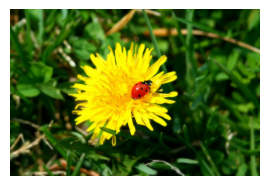

In [82]:
#군집을 이용한 이미지 분할
from matplotlib.image import imread
import matplotlib.pyplot as plt
image = imread('./data/ladybug.png')
print(image.shape)

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.subplot(231)
plt.imshow(image)
plt.axis('off')

In [83]:
#색상을 가지고 군집을 수행
from sklearn.cluster import KMeans
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

#각 필셀이 속한 클러스터의 중앙 좌표를 저장
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

#print(segmented_img)

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[[0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  ...
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]]

 [[0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  ...
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]]

 [[0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  ...
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]
  [0.21914566 0.38675916 0.05800837]]

 ...

 [[0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
  ...
  [0.09991629 0.25424525 0.01694096]
  [0.09991629 0.25424525 0.01694096]
  [0.02288038 0.11069143 0.00578684]]

 [[0.02288038 0.11069143 0.00578684]
  [0.02288038 0.11069143 0.00578684]
